In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import os
from io import StringIO

cwd = os.getcwd() # Get direction

In [2]:
import json
import requests
from urllib.request import urlopen
import plotly.express as px

### Function to generate dataframe from USDA API

In [3]:
# http direction 
nass_base = 'http://quickstats.nass.usda.gov/api/api_GET?'
# My personal key
key= '1897574B-86B2-3182-B9C3-3BFF302E3042'

def api_nass(api_params, key):
    apidata = requests.get(nass_base, params=api_params)
    apidata = apidata.json()
    df = pd.DataFrame.from_dict(apidata['data'])
    return df

### Function to append especific variables for several years by "area operated" from Ag Census. 
#### Returns dataframe with time series format

In [4]:
def dataframe_usda(varlist,key, years, sector ,commodity,domain,geolevel, separ, label_index):
    dfA = pd.DataFrame(columns=['year','state_fips_code','state_name','domaincat_desc'])

    for z in varlist:
        label= z.split(separ)[label_index]
        dfB = pd.DataFrame()
        for y in years:

            # Parameters for land tenure data
            area_params = {'key': key,
                       'sector_desc': sector,
                       'commodity_desc': commodity,
                       'domain_desc': domain,
                       'short_desc': z,
                       'agg_level_desc': geolevel.upper(),
                       'year': y}
            df= api_nass(area_params, key)
            df[label]= df['Value'].str.replace(',', '')
            df[label]= pd.to_numeric(df[label], errors='coerce')

            # merge number of operations (farms) with area

            filt=['year','state_name','state_fips_code','domaincat_desc',label]

            dfB=dfB.append(df[filt], 'sort=False') #append years

        dfA=dfA.merge(dfB, how='outer', on=['year','state_fips_code','state_name','domaincat_desc']) #merge vars          

    return dfA

### Data on agricultural practices

In [5]:
pract_acre=['PRACTICES, LAND USE, CONSERVATION EASEMENT - ACRES','PRACTICES, LAND USE, CROPLAND, CONSERVATION TILLAGE, (EXCL NO-TILL) - ACRES',
            'PRACTICES, LAND USE, CROPLAND, CONSERVATION TILLAGE, NO-TILL - ACRES','PRACTICES, LAND USE, CROPLAND, CONVENTIONAL TILLAGE - ACRES',
           'PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - ACRES','PRACTICES, LAND USE, DRAINED BY ARTIFICIAL DITCHES - ACRES',
           'PRACTICES, LAND USE, DRAINED BY TILE - ACRES']

pract_ope=['PRACTICES, LAND USE, CONSERVATION EASEMENT - NUMBER OF OPERATIONS','PRACTICES, LAND USE, CROPLAND, CONSERVATION TILLAGE, (EXCL NO-TILL) - NUMBER OF OPERATIONS',
           'PRACTICES, LAND USE, CROPLAND, CONSERVATION TILLAGE, NO-TILL - NUMBER OF OPERATIONS','PRACTICES, LAND USE, CROPLAND, CONVENTIONAL TILLAGE - NUMBER OF OPERATIONS',
          'PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - NUMBER OF OPERATIONS','PRACTICES, LAND USE, DRAINED BY ARTIFICIAL DITCHES - NUMBER OF OPERATIONS',
          'PRACTICES, LAND USE, DRAINED BY TILE - NUMBER OF OPERATIONS']
dfprac= dataframe_usda(pract_acre+pract_ope,key,[2012,2017],'ECONOMICS','PRACTICES','AREA OPERATED','state',separ=', ',label_index=-1) #dataframe of practices in agriculture

In [8]:
dfprac.columns

Index(['year', 'state_name', 'state_fips_code', 'domaincat_desc',
       'CONSERVATION EASEMENT - ACRES', '(EXCL NO-TILL) - ACRES',
       'NO-TILL - ACRES', 'CONVENTIONAL TILLAGE - ACRES', '(EXCL CRP) - ACRES',
       'DRAINED BY ARTIFICIAL DITCHES - ACRES', 'DRAINED BY TILE - ACRES',
       'CONSERVATION EASEMENT - NUMBER OF OPERATIONS',
       '(EXCL NO-TILL) - NUMBER OF OPERATIONS',
       'NO-TILL - NUMBER OF OPERATIONS',
       'CONVENTIONAL TILLAGE - NUMBER OF OPERATIONS',
       '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY ARTIFICIAL DITCHES - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS'],
      dtype='object')

In [11]:
A= ['(EXCL CRP) - ACRES',
     'DRAINED BY TILE - ACRES',
    '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS']
df=dfprac[A]
df.dropna(how='all')

,(EXCL CRP) - ACRES,DRAINED BY TILE - ACRES,(EXCL CRP) - NUMBER OF OPERATIONS,DRAINED BY TILE - NUMBER OF OPERATIONS
0,51652.0,8750.0,148.0,69.0
1,3908.0,NaN,13.0,6.0
2,34967.0,121994.0,85.0,123.0
3,56062.0,77528.0,140.0,135.0
4,27217.0,15089.0,144.0,54.0
...,...,...,...,...
1190,NaN,NaN,1.0,NaN
1191,3820.0,NaN,3.0,NaN
1194,NaN,NaN,1.0,1.0
1195,NaN,NaN,1.0,NaN


### Data of land size categories

In [12]:
cat=['AG LAND, CROPLAND, HARVESTED - ACRES','AG LAND, CROPLAND, HARVESTED - NUMBER OF OPERATIONS']
dfland= dataframe_usda(cat,key, [2012,2017], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ='- ',label_index=-1)

In [13]:
dfland

,year,state_name,state_fips_code,domaincat_desc,ACRES,NUMBER OF OPERATIONS
0,2012,ALABAMA,01,"AREA OPERATED: (1,000 TO 1,999 ACRES)",387991.0,671
1,2012,ALASKA,02,"AREA OPERATED: (1,000 TO 1,999 ACRES)",4643.0,12
2,2012,ARIZONA,04,"AREA OPERATED: (1,000 TO 1,999 ACRES)",151485.0,183
3,2012,ARKANSAS,05,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1628050.0,1601
4,2012,CALIFORNIA,06,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1285858.0,1389
...,...,...,...,...,...,...
1390,2017,VIRGINIA,51,AREA OPERATED: (70.0 TO 99.9 ACRES),83075.0,2929
1391,2017,WASHINGTON,53,AREA OPERATED: (70.0 TO 99.9 ACRES),43405.0,1014
1392,2017,WEST VIRGINIA,54,AREA OPERATED: (70.0 TO 99.9 ACRES),50300.0,2259
1393,2017,WISCONSIN,55,AREA OPERATED: (70.0 TO 99.9 ACRES),183051.0,4623


In [14]:
## Clean data
#Select categories
selection=['AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)']
# New dataset with selected categories of land size    
dfland1= dfland.loc[dfland['domaincat_desc'].isin(selection)]
#### Define upper and lower bounds of land size tabulated data
# Extract numbers (acres) from column: categories description
dfland1['farmcat']=dfland1['domaincat_desc']
dfland1['farmcat']= dfland1['farmcat'].str.replace(',', '', regex=True)
dfland1['farmcat']= dfland1['farmcat'].str.replace('.0', '', regex=False)
dfland1['farmcat']= dfland1['farmcat'].str.replace('.9', '', regex=False)

dfs = dfland1['farmcat'].str.findall('\d+').to_frame()
dfland1['lower_bound']= dfs.apply(lambda x: x.str[0])
dfland1['upper_bound']= dfs.apply(lambda x: x.str[1])

dfland1['lower_bound']=dfland1['lower_bound'].astype(int)
dfland1['upper_bound']=pd.to_numeric(dfland1['upper_bound'], errors='coerce')
#dfland1['upper_bound'].astype(int)


/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### Data on policies in terms of land area

In [15]:
varlist= ['AG LAND, CROP INSURANCE - ACRES','AG LAND, CROP INSURANCE - NUMBER OF OPERATIONS','AG LAND, IRRIGATED - NUMBER OF OPERATIONS',
         'AG LAND, RENTED FROM OTHERS, IN FARMS - ACRES','AG LAND, RENTED FROM OTHERS, IN FARMS - NUMBER OF OPERATIONS',
         'AG LAND, OWNED, IN FARMS - ACRES','AG LAND, OWNED, IN FARMS - NUMBER OF OPERATIONS']
dfcrop= dataframe_usda(varlist,key, [2012,2017], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ=', ',label_index=1)
'AREA OPERATED AND AREA CROPLAND, HARVESTED'

'AREA OPERATED AND AREA CROPLAND, HARVESTED'

In [16]:
## irrigated land in acres (only cropland)
varlist= ['AG LAND, CROPLAND, HARVESTED, IRRIGATED - ACRES','AG LAND, CROPLAND, HARVESTED, IRRIGATED - NUMBER OF OPERATIONS']
dfirr= dataframe_usda(varlist,key, [2012,2017], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ=', ',label_index=3)


###  Data on business operations: income and expenses

In [7]:
## Variable list of farm operations grouped by 'commodity(labor, feed, etc)' description
varlist = [['INCOME, NET CASH FARM, OF OPERATIONS - NET INCOME, MEASURED IN $ / OPERATION'], #net income
       ['GOVT PROGRAMS, FEDERAL - RECEIPTS, MEASURED IN $','GOVT PROGRAMS, FEDERAL - OPERATIONS WITH RECEIPTS'], #federal programs
       ['LABOR, HIRED - EXPENSE, MEASURED IN $','LABOR, HIRED - OPERATIONS WITH EXPENSE',
        'LABOR, HIRED - NUMBER OF WORKERS','LABOR, HIRED - OPERATIONS WITH EXPENSE'],#labor
          ['INCOME, FARM-RELATED - RECEIPTS, MEASURED IN $','INCOME, FARM-RELATED - OPERATIONS WITH RECEIPTS', # farm-related income
          'INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - RECEIPTS, MEASURED IN $', # local and state government transfers
           'INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - OPERATIONS WITH RECEIPTS'],
          ['FERTILIZER TOTALS, INCL LIME & SOIL CONDITIONERS - EXPENSE, MEASURED IN $', #fertilizer
           'FERTILIZER TOTALS, INCL LIME & SOIL CONDITIONERS - OPERATIONS WITH EXPENSE'],
        # "LABOR, CONTRACT - EXPENSE, MEASURED IN $",'LABOR, CONTRACT - OPERATIONS WITH EXPENSE',
           #['SEEDS & PLANTS TOTALS - EXPENSE, MEASURED IN $','SEEDS & PLANTS TOTALS - OPERATIONS WITH EXPENSE'],
       #['RENT, CASH, LAND & BUILDINGS - EXPENSE, MEASURED IN $',"RENT, CASH, LAND & BUILDINGS - OPERATIONS WITH EXPENSE"],
      #['FUELS, INCL LUBRICANTS - EXPENSE, MEASURED IN $','FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE'],
      #['EXPENSE TOTALS, OPERATING - EXPENSE, MEASURED IN $','EXPENSE TOTALS, OPERATING - OPERATIONS WITH EXPENSE'],
      #['CHEMICAL TOTALS - EXPENSE, MEASURED IN $','CHEMICAL TOTALS - OPERATIONS WITH EXPENSE'],
        #['FEED - OPERATIONS WITH EXPENSE',],
      ['EXPENSE TOTALS, OPERATING - EXPENSE, MEASURED IN $ / OPERATION'],
      ['CCC LOANS - RECEIPTS, MEASURED IN $','CCC LOANS - OPERATIONS WITH RECEIPTS']]
commodity = ['INCOME, NET CASH FARM','GOVT PROGRAMS','LABOR','INCOME, FARM-RELATED','FERTILIZER TOTALS','EXPENSE TOTALS','CCC LOANS']
             #,'SEEDS & PLANTS TOTALS','RENT','FUELS','EXPENSE TOTALS','CHEMICAL TOTALS','FEED',]


In [10]:
dfop= pd.DataFrame(columns=['year','state_fips_code','state_name','domaincat_desc'])
for var,co in zip(varlist, commodity):
    try:
        df= dataframe_usda(var,key,[2012,2017],'ECONOMICS',co,'AREA OPERATED','state',', ',label_index=1)
    except:
        df= dataframe_usda(var,key,[2012,2017],'ECONOMICS',co,'AREA OPERATED','state',', ',label_index=0)
    dfop=dfop.merge(df, how='outer', on=['year','state_fips_code','state_name','domaincat_desc']) #merge dataframes          
    

### Data on access to machinery

In [79]:
varlist= ['MACHINERY TOTALS - ASSET VALUE, MEASURED IN $', 'MACHINERY TOTALS - OPERATIONS WITH ASSET VALUE']
dftech= dataframe_usda(varlist,key, [2012,2017], 'ECONOMICS','MACHINERY TOTALS','AREA OPERATED','state',separ=' - ',label_index=0)


### Farm-related income by NAICS classification

In [12]:
varlist= ['INCOME, FARM-RELATED - RECEIPTS, MEASURED IN $']
dfnaics= dataframe_usda(varlist,key, [2012,2017], 'ECONOMICS','INCOME, FARM-RELATED','NAICS CLASSIFICATION','state',separ=' - ',label_index=0)


In [13]:
## Quantify income related to harvesting activities
dfnaics['naics']= dfnaics['domaincat_desc'].str.split().str[2].str[3] #'1'=harvesting , '2'=livestock
dfnaics['naics'].replace('2','0', inplace=True)
dfnaics['naics']= dfnaics['naics'].astype(int)
dfnaics['harv_inc']= dfnaics['naics']* dfnaics['INCOME, FARM-RELATED'] #aggregate harvesting income
dfnaics['cropsincome_share']= (dfnaics.groupby(['year','state_fips_code'])['harv_inc'].transform('sum'))/(dfnaics.groupby(['year','state_fips_code'])['INCOME, FARM-RELATED'].transform('sum'))
dfnaics.drop_duplicates(subset= ['year','state_fips_code'], inplace= True)

### Data on cropland use from CropScape

In [5]:

def getstat_cdl(year1,fipscode):
    url='https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLStat?year='+year1+'&fips='+fipscode+'&format=csv'
    response = requests.get(url).text
    d= response.find('https://nassgeodata.gmu.edu/webservice/nass_data_cache/')
    e= response.find('.csv')
    g= response[d:e+4]
    df=pd.read_csv(g)
    return df


In [6]:
def clean_cropsdata(df):
    df=df.rename(columns={'Value':'cropcode',' Category':'cropname' , '  Acreage':'Acreage'}) 
    df['cropname']=df['cropname'].str[1:]
    return df

In [23]:
def cropland_entropy(df):
    
    dfe= df.groupby(['catname'])[['Acreage']].sum() # add by main crop categories: grain, fruit, veg, 
    dfe['p'] = dfe['Acreage']/(dfe['Acreage'].sum())
    dfe['plnp']= np.log(dfe['p'])*dfe['p']
    
    return -(dfe['plnp'].sum()) #Shannon entropy

In [8]:
## Open crop categories
dfcdl= pd.read_csv(cwd[:-4]+'/Data/CDL_crops_categ.csv')


In [9]:
### Remove land uses not related to crops
remove= ['wetland','woodland','grass']


In [54]:
## Iterate over three periods of time and every state
dfen= pd.DataFrame() 

for state in list(dfprac['state_fips_code'].unique()):
    for year in ['2008', '2012', '2017']:
        try:
            df= getstat_cdl(year,state)
            df= clean_cropsdata(df)
            dfc= pd.merge(df, dfcdl[['cropcode','Category','catname']], on=['cropcode'], how='outer')
            ## keep only crops, remove woodlands, grassland and wetland
            dfc1 = dfc[(dfc['catname'].isin(remove) == False)]
            dfc1.dropna(how= 'any', inplace=True)
            entropy= cropland_entropy(dfc1) #compute cropland entropy
            # append entropy measurements in dataframe
            dfen= dfen.append({'state_fips_code': state,'year': year,'cropland_entropy':entropy}, ignore_index=True)
            ## get wetlands, woodlands and grasslands
            
        except:
            print(state, year)
            #pass
            

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


15 2008
15 2012
15 2017
02 2008
02 2012
02 2017


,cropland_entropy,state_fips_code,year,entrop2008,var_entropy
1,1.072441,01,2012,0.990007,0.083266
2,1.110475,01,2017,0.990007,0.121684
4,1.415576,04,2012,1.274358,0.110815
5,1.311499,04,2017,1.274358,0.029145
7,0.339720,05,2012,0.399502,-0.149640
...,...,...,...,...,...
137,0.635764,55,2017,0.685645,-0.072750
139,0.701051,56,2012,0.520715,0.346324
140,0.525864,56,2017,0.520715,0.009888
142,0.781633,44,2012,0.941264,-0.169591


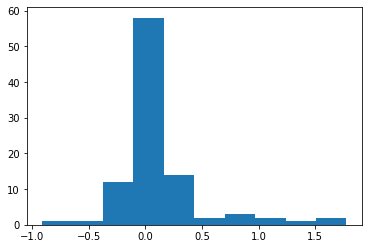

In [56]:
## Entropy variation rates with respect to 2008
dfen['entrop2008']= dfen['cropland_entropy'][dfen['year']=='2008']
dfen['entrop2008']= dfen.groupby(['state_fips_code'])['entrop2008'].transform('max')
dfen['var_entropy']= (dfen['cropland_entropy']- dfen['entrop2008'])/(dfen['entrop2008'])
dfen1= dfen[dfen['year']!='2008']
plt.hist(dfen1['var_entropy'])
dfen1

### Data on operations by NAICS and farm size

In [24]:
varlist= ['FARM OPERATIONS - NUMBER OF OPERATIONS']
dfliv= dataframe_usda(varlist,key, [2012,2017], 'ECONOMICS','FARM OPERATIONS','AREA OPERATED AND NAICS CLASSIFICATION','state',separ=' - ',label_index=0)

In [25]:
dfliv['domain']= dfliv['domaincat_desc']
dfliv['naics']= dfliv['domain'].str.split(' AND ').str[1]
dfliv['domaincat_desc']= dfliv['domain'].str.split(' AND ').str[0]
## Quantify livestock farming by farmsize
dfliv['naics']= dfliv['naics'].str.split(': ').str[1].str[3] #'1'=harvesting , '2'=livestock
dfliv['naics'].replace('1','0', inplace=True)
dfliv['naics'].replace('2','1', inplace=True)
dfliv['naics']= dfliv['naics'].astype(int)
dfliv['livestock_farm']= dfliv['naics']* dfliv['FARM OPERATIONS'] #get number of livestock farm
dfliv['livestockfarm_share']= (dfliv.groupby(['year','state_fips_code','domaincat_desc'])['livestock_farm'].transform('sum'))/(dfliv.groupby(['year','state_fips_code','domaincat_desc'])['FARM OPERATIONS'].transform('sum'))
dfliv.drop_duplicates(subset= ['year','state_fips_code','domaincat_desc'], inplace= True)


### Precipitation Data from NOAA

In [25]:
def precipitation_data(st, year1, year2):
    url= 'https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/'+st+'-pcp-all-1-'+year1+'-'+year2+'.json?base_prd=true&begbaseyear=1901&endbaseyear=2000'
    response = urlopen(url)
    data_json = json.loads(response.read())
    
    df= pd.DataFrame.from_dict(data_json['data'], orient='index')
    
    return df, data_json['description']['title'][:-15]

In [26]:
def precipitation_change(df):
    df.loc[df['anomaly'].str[0]=='-', 'negative anomaly'] = 1
    df.loc[df['anomaly'].str[0]!='-', 'positive anomaly'] = 1
    
    df.replace([np.nan, -np.nan], 0, inplace=True)
    
    df['value']= df['value'].astype(float)
    df['anomaly']= df['anomaly'].astype(float)
    
    df['positive anomaly']= df['positive anomaly']*df['anomaly']
    df['negative anomaly']= df['negative anomaly']*df['anomaly']
    
    return {'meanpcp': np.mean(df['value']), 'varpcp': np.var(df['value']), 
            'meanpospcp': np.mean(df['positive anomaly']), 'varpospcp':np.var(df['positive anomaly']),
           'meannegpcp': np.mean(df['negative anomaly']), 'varnegpcp':np.var(df['negative anomaly'])}

In [27]:
dfpcp= pd.DataFrame(columns=('state_name','year','meanpcp','varpcp','meanpospcp','varpospcp','meannegpcp','varnegpcp'))

for st in list(range(1,50)):
    for x,z in zip(['2000','2005'],['2012','2017']):
        try:
            df, state = precipitation_data(str(st), x,z) #get json data in dataframe
            D= {}
            D= precipitation_change(df) # get dictionary of mean and var values
            D['state_name']= state.upper()
            D['year']= int(z)
            dfpcp= dfpcp.append(D, ignore_index=True)

        except:
            pass
    

### Climate data from Matthew Kling Github Repository

In [15]:
dfw= pd.read_csv('https://raw.githubusercontent.com/matthewkling/ca2cc-county/main/data/output/wide_data.csv')

In [16]:
#dfw.columns[350:400]
#dfw= dfw[['fips','climate_cwd_growing_season_2007_2011','climate_cwd_growing_season_2012_2016', 'climate_edd_growing_season_2007_2011','climate_edd_growing_season_2012_2016']]
dfw= dfw[['fips', 'climate_ffp_z_full_year_2007_2011',
       'climate_ffp_z_full_year_2012_2016','climate_ffp_full_year_2007_2011', 'climate_ffp_full_year_2012_2016']]

In [19]:
## Arrange data per column variable
cols= list(dfw.columns.values)

dfcl= pd.DataFrame(columns=['fips','year'])

def clean_df(df, col, year): ## function to identify year in the data
    df1= df[['fips',col]]
    df1['year']= year
    df1.rename(columns={col: col[:-10]}, inplace=True)
    return df1

for col in cols[1:]:
    
    #if '1982' in col[-10:]:
        #df1= clean_df(dfw, col, 1982)
    if '2007' in col[-10:]:
        df1= clean_df(dfw, col, 2012)
    
    else:
        df2= clean_df(dfw, col, 2017)
        
        df= pd.concat([df1, df2], axis= 0)
        dfcl= pd.merge(dfcl, df, on=['fips','year'], how='outer')
    

/var/folders/7w/z3mdh4qx70v7ppq9m1yhchtm0000gn/T/ipykernel_2325/3563943457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year']= year
/var/folders/7w/z3mdh4qx70v7ppq9m1yhchtm0000gn/T/ipykernel_2325/3563943457.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={col: col[:-10]}, inplace=True)
/var/folders/7w/z3mdh4qx70v7ppq9m1yhchtm0000gn/T/ipykernel_2325/3563943457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [20]:
dfcl

,fips,climate_ffp_z_full_year,year,climate_ffp_full_year
0,1001,-0.100455,2012,244.000777
1,1003,-0.281876,2012,268.183803
2,1005,0.156816,2012,251.939958
3,1007,0.115422,2012,228.781716
4,1009,0.698678,2012,230.658900
...,...,...,...,...
6287,56037,0.897125,2017,111.401546
6288,56039,0.600557,2017,79.655471
6289,56041,1.161948,2017,123.086864
6290,56043,0.396796,2017,150.369694


In [21]:
#dfcl= dfcl.loc[dfcl['year']> 1982]
dfcl['state_fips_code']= dfcl['fips'].astype(str).str[:-3].str.zfill(2)
# Compute state averages
dfcl_mean= dfcl.groupby(['state_fips_code','year'])['climate_ffp_full_year','climate_ffp_z_full_year'].mean().reset_index()

/var/folders/7w/z3mdh4qx70v7ppq9m1yhchtm0000gn/T/ipykernel_2325/776288365.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfcl_mean= dfcl.groupby(['state_fips_code','year'])['climate_ffp_full_year','climate_ffp_z_full_year'].mean().reset_index()


### Data on Agriculture Exports and Value-Added

#### Farm GDP by state

In [77]:
#file=cwd[:-4]+'Data/SAGDP2N__ALL_AREAS_1997_2020.csv' #thousands of dollars
dfg= pd.read_csv(cwd[:-4]+'/Data/SAGDP7N__ALL_AREAS_1997_2020.csv',low_memory=False)

In [69]:
dfg.rename(columns={'GeoFIPS':'state_fips_code'}, inplace=True)
# Clean geography_orig
dfg['state_fips_code'] = dfg['state_fips_code'].str[2:-4]
    
# Convert area-code to number type
dfg['state_fips_code'] = pd.to_numeric(dfg['state_fips_code'], errors='coerce').fillna(0)
    
# Filter by 50 states
dfg=dfg.loc[(dfg['state_fips_code'] >= 1) & (dfg['state_fips_code'] <= 56)]
dfg['state_fips_code']= dfg['state_fips_code'].astype(str).str.zfill(2)
# Filter by 'all' GDP
dfg= dfg.loc[(dfg['Description'] == 'All industry total')]

### 2012 data
dfg1= dfg[['state_fips_code','GeoName','2012']]
dfg1['year']= 2012
dfg1.rename(columns= {'2012': 'gdp'}, inplace=True)

### 2017 data
dfg2= dfg[['state_fips_code','GeoName','2017']]
dfg2['year']= 2017
dfg2.rename(columns= {'2017': 'gdp'}, inplace=True)

dfg= pd.DataFrame()
dfg= dfg1.append(dfg2)

dfg['state_fips_code']= pd.to_numeric(dfg['state_fips_code'], errors='coerce').astype(int)


/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Agricultural exports

In [45]:
df= pd.read_csv(cwd[:-4]+'/Data/agrexports_bystate.csv') ##millions of dollars
df['Fips']= df['Fips'].astype(str).str.zfill(2)
df.rename(columns={'Fips': 'state_fips_code'}, inplace=True)


In [46]:

# Compute export variation rates
cols = list(df.columns.drop(['state_fips_code', 'State']))
df[cols] = df[cols].replace(',','', regex=True).astype(float)
    
df['var2011']= (df['2011']-df['2010'])/df['2010']
df['var2016']= (df['2016']-df['2015'])/df['2015']

df1= df[['state_fips_code','var2011', '2012']]
df1['year']= 2012
df1.rename(columns= {'var2011': 'expect_agroexp', '2012':'agroexp'}, inplace=True)

df2= df[['state_fips_code','var2016','2017']]
df2['year']= 2017
df2.rename(columns= {'var2016': 'expect_agroexp','2017':'agroexp'}, inplace=True)

dfx= df1.append(df2)
dfx['state_fips_code']= dfx['state_fips_code'].astype(int)

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Data on soil erosion from NRCS

In [4]:
## State abbreviations and regions
dfs= pd.read_csv(cwd[:-4]+'/Data/us_states.csv')
dfs['Fips']= dfs['Fips'].astype(str).str.zfill(2)
dfs.rename(columns={'Fips': 'state_fips_code', 'Abbreviation': 'state_abb'}, inplace=True)


In [37]:
def get_erosion_data(state):
    
    url= 'https://www.nrcs.usda.gov/Internet/NRCS_RCA/csv/nri_download_'+state+'.csv'
    res = requests.get(url).content
    d= res.find(b'Water (Sheet & Rill) and Wind Erosion on Cropland')
    e= res.find(b'Rate of Wind Erosion in Tons Per Acre Per Year')
    g= res[d+77:e]
    s = str(g, 'utf-8')
    data = StringIO(s)
    df= pd.read_csv(data)
    df.reset_index(inplace=True)
    cols= df.columns.values.tolist()
    df.columns= cols[1:]+['n']
    return df

In [38]:
dfero= pd.DataFrame(columns= ('state_abb','year','erosion_rate'))
for state in list(dfs['state_abb'].unique()):
    try:
        df= get_erosion_data(state.lower())
        for year in ['2012','2017']:
            col= ' '+year+' Estimate' #get erosion estimate
            rate= df[col][df['level_1']=='Rate of Water Erosion in Tons Per Acre Per Year ']
            dfero= dfero.append({'state_abb': state,'year': year,'erosion_rate':rate.values[0]}, ignore_index=True)
    except:
        print(state)
        pass

AK
DC


## Data on total area by state

In [13]:
dfar= pd.read_csv(cwd[:-4]+'/Data/state_area.csv')

In [14]:
dfar= pd.merge(dfar[['State','land_sqmi']], dfs[['State','state_abb']], on=['State'])


In [29]:
dfar['land_sqmi']= dfar['land_sqmi'].str.replace(',', '')
dfar['land_sqmi']= pd.to_numeric(dfar['land_sqmi'], errors='coerce')


State        object
land_sqmi     int64
state_abb    object
dtype: object

### Data on Agricultural values and prices

In [50]:
#dfv= pd.read_csv(cwd[:-4]+'/Data/agvalues_states.csv')
dfv['state_fips_code']= dfv['state_fips_code'].astype(str).str.zfill(2)
dfv

,Unnamed: 0,land_price,land_price_var,year,subregion,cropland_value,cropland_value_var,state_fips_code
0,Connecticut,11100,-3.5,2012,Northeast,6940,-1.4,09
1,Delaware,8100,0.0,2012,Northeast,7800,0.0,10
2,Maine,1970,-1.5,2012,Northeast,6940,-1.4,23
3,Maryland,7200,0.0,2012,Northeast,7000,0.0,24
4,Massachusetts,10500,-4.5,2012,Northeast,6940,-1.4,25
...,...,...,...,...,...,...,...,...
91,Utah,2070,1.5,2017,Mountain,3420,2.4,49
92,Wyoming,660,0.0,2017,Mountain,1350,-1.5,56
93,California,8700,10.1,2017,Pacific,11290,3.5,06
94,Oregon,2310,5.0,2017,Pacific,2860,4.8,41


### Merge datasets

In [80]:
DF=pd.DataFrame()
DF= pd.merge(dfland1, dfprac, on=['year','state_fips_code','state_name','domaincat_desc'])
DF= pd.merge(DF, dfcrop, on=['year','state_fips_code','state_name','domaincat_desc'])
DF= pd.merge(DF, dfirr, on=['year','state_fips_code','state_name','domaincat_desc'])

DF= pd.merge(DF, dfop, on=['year','state_fips_code','state_name','domaincat_desc'])
DF= pd.merge(DF, dftech, on=['year','state_fips_code','state_name','domaincat_desc'])
#DF= pd.merge(DF, dfnaics[['year','state_fips_code','state_name','cropsincome_share']], on=['year','state_fips_code','state_name'])
#DF= pd.merge(DF, dfdiv[['year','state_fips_code','state_name','agland_entropy']], on=['year','state_fips_code','state_name'])
DF= pd.merge(DF, dfliv[['year','state_fips_code','state_name','domaincat_desc','livestockfarm_share']], on=['year','state_fips_code','state_name','domaincat_desc'])

#DF= pd.merge(DF, dfcl, on=['year','state_fips_code'])
dfen1['year']= dfen1['year'].astype(int)
DF= pd.merge(DF, dfen1, on=['year','state_fips_code'])

DF= pd.merge(DF, dfg, on=['year','state_fips_code'])
DF= pd.merge(DF, dfx, on=['year','state_fips_code'])

DF= pd.merge(DF, dfcl_mean, on=['year','state_fips_code'])

DF= pd.merge(DF, dfs[['state_abb','state_fips_code','Region','Subregion']], on=['state_fips_code'])
dfero['year']= dfero['year'].astype(int)
DF= pd.merge(DF, dfero, on=['state_abb', 'year']) #erosion

DF= pd.merge(DF, dfar[['state_abb','land_sqmi']], on=['state_abb']) #state areas

DF= DF.sort_values(['year','state_fips_code','lower_bound'])

DF['farmcat']=DF['farmcat'].str[16:-7]


/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')
#DF['state_fips_code']= DF['state_fips_code'].astype(str).str.zfill(2)
#DF.drop(['Unnamed: 0'], axis=1, inplace=True)
#DF= pd.merge(DF, dfcl_mean, on=['year','state_fips_code'])

In [13]:
(DF['(EXCL CRP) - ACRES']==0).sum()

0

In [14]:
DF

,year,state_name,state_fips_code,domaincat_desc,ACRES,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,CONSERVATION EASEMENT - ACRES,...,state_code_54,state_code_55,state_code_56,cropland_insured,land_sqmi,cropland_share,climate_edd_z_full_year,climate_prec_z_full_year,climate_ffp_full_year,climate_ffp_z_full_year
0,2012,ALABAMA,1,AREA OPERATED: (1.0 TO 9.9 ACRES),2607.0,861,1 TO 9,1,9.000000,64.0,...,0,0,0,0.023782,50645,0.066579,0.821545,-0.371258,233.566055,0.112911
1,2012,ALABAMA,1,AREA OPERATED: (10.0 TO 49.9 ACRES),64793.0,4879,10 TO 49,10,49.000000,1676.0,...,0,0,0,0.047274,50645,0.066579,0.821545,-0.371258,233.566055,0.112911
2,2012,ALABAMA,1,AREA OPERATED: (50.0 TO 69.9 ACRES),45288.0,1900,50 TO 69,50,69.000000,832.0,...,0,0,0,0.097355,50645,0.066579,0.821545,-0.371258,233.566055,0.112911
3,2012,ALABAMA,1,AREA OPERATED: (70.0 TO 99.9 ACRES),63221.0,2313,70 TO 99,70,99.000000,2847.0,...,0,0,0,0.092343,50645,0.066579,0.821545,-0.371258,233.566055,0.112911
4,2012,ALABAMA,1,AREA OPERATED: (100 TO 139 ACRES),83054.0,2333,100 TO 139,100,139.000000,2212.0,...,0,0,0,0.124124,50645,0.066579,0.821545,-0.371258,233.566055,0.112911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),17315.0,150,220 TO 259,220,259.000000,795.0,...,0,0,1,0.210049,97093,0.024861,0.020195,-0.078232,126.995260,0.632982
1142,2017,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),90829.0,535,260 TO 499,260,499.000000,5216.0,...,0,0,1,0.339418,97093,0.024861,0.020195,-0.078232,126.995260,0.632982
1143,2017,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),156182.0,576,500 TO 999,500,999.000000,12309.0,...,0,0,1,0.464855,97093,0.024861,0.020195,-0.078232,126.995260,0.632982
1144,2017,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",239152.0,507,1000 TO 1999,1000,1999.000000,21320.0,...,0,0,1,0.486402,97093,0.024861,0.020195,-0.078232,126.995260,0.632982


### Land distribution

In [83]:
### Fill 'upper bound' with national mean values
#Get mean acres by farm class and state
DF['acres_per_farm']= DF['ACRES']/DF['NUMBER OF OPERATIONS']
# Get mean acres by farm class (national level)
DF['acres_category']= DF.groupby(['year','domaincat_desc'])['acres_per_farm'].transform('max')
# Fill upper bound
DF['upper_bound']= DF['upper_bound'].fillna((DF['acres_category'][DF['domaincat_desc']=='AREA OPERATED: (2,000 OR MORE ACRES)'])*2)

# Replace missing values in Acres with the midpoint of the upper and lower bounds of the tabulated data of acres 
DF['ACRES']= DF['ACRES'].fillna((DF['upper_bound'])*(DF['NUMBER OF OPERATIONS']))


In [84]:
##### Share of cropland acres
DF['acres_tot']= DF.groupby(['year','state_fips_code'])['ACRES'].transform('sum')
DF['share_acres']= DF['ACRES']/DF['acres_tot']
# share of population (i.e %farms)
DF['farms_tot']= DF.groupby(['year','state_fips_code'])['NUMBER OF OPERATIONS'].transform('sum')
DF['share_farms']= DF['NUMBER OF OPERATIONS']/DF['farms_tot']
# Compute accumulative shares
DF= DF.sort_values(['year','state_fips_code','lower_bound'])
DF['acres_cum']= DF.groupby(['year','state_fips_code'])['share_acres'].cumsum()
DF['farms_cum']= DF.groupby(['year','state_fips_code'])['share_farms'].cumsum()

## Create a variable that measures the ratio: land share/operations (# farms) share
DF['land_concent']= DF['share_acres']/DF['share_farms']

##### Proportion of rented land
DF['rented_land']= DF['RENTED FROM OTHERS - ACRES']/(DF['OWNED - ACRES']+DF['RENTED FROM OTHERS - ACRES'])

#### Proportion of Insured land
DF['insured_farms']= DF['CROP INSURANCE - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']
DF['cropland_insured']= DF['CROP INSURANCE - ACRES']/DF['ACRES']

In [27]:
#### Proportion of irrigated cropland, harvested
DF['irrigated_cropland']= DF['IRRIGATED - ACRES']/DF['ACRES']
DF['irrigated_farms']= DF['IRRIGATED - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']

### Adaptation practices in % share of acres

In [85]:
DF['conservation easement']= DF['CONSERVATION EASEMENT - ACRES']/DF['ACRES']
DF['conservation till']= DF['(EXCL NO-TILL) - ACRES']/DF['ACRES']
DF['no till']= DF['NO-TILL - ACRES']/DF['ACRES']
DF['conventional till']= DF['CONVENTIONAL TILLAGE - ACRES']/DF['ACRES']
DF['cover_crops']= DF['(EXCL CRP) - ACRES']/DF['ACRES']
DF['tile']= DF['DRAINED BY TILE - ACRES']/DF['ACRES']
DF['ditches']= DF['DRAINED BY ARTIFICIAL DITCHES - ACRES']/DF['ACRES']

#### Adaptation practices in % of operations

In [22]:
DF['covercrops_num']=DF['(EXCL CRP) - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']
DF['tile_num']=DF['DRAINED BY TILE - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']
DF['ditches_num']= DF['DRAINED BY ARTIFICIAL DITCHES - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']

In [29]:
# Year 2017 dummy
DF.loc[DF['year'] == 2017, 'year_2017'] = 1
DF['year_2017'].replace(np.nan, 0, inplace=True)

### Farm class: small, medium and large farms

In [86]:
#DF['farmcat']=DF['farmcat'].str[16:-7]
DF['class'] = DF['farmcat']
DF.replace({'class':{'1 TO 9': 0, '10 TO 49': 0, '50 TO 69': 0, '70 TO 99': 0, 
                     '100 TO 139': 1,'140 TO 179': 1, '180 TO 219': 1, '220 TO 259': 1,
                     '260 TO 499': 2,'500 TO 999':2, '1000 TO 1999':2, '2000 OR MORE':2}},inplace=True)

DF['farm class']= DF['class'].astype('category').map({0: 'Small', 1: 'Medium', 2: 'Large'})

### Farm Operations

In [87]:
## Create a variable 'new total operations' that takes the bigger number of operations between
# receiving income and federal transfers. 
# This variable will be used to determine the actual fed gov transf coverage with respect to farm income 
vals = []

for i, row in DF.iterrows():
    if row['FEDERAL - OPERATIONS WITH RECEIPTS'] > row['FARM-RELATED - OPERATIONS WITH RECEIPTS']:
        vals.append(row['FEDERAL - OPERATIONS WITH RECEIPTS'])
    else:
        vals.append(row['FARM-RELATED - OPERATIONS WITH RECEIPTS'])

DF['new_totoper'] = vals

In [88]:
### Mean net income
DF['mean_netincome']= DF['NET CASH FARM']

DF['tot_income']= DF['FARM-RELATED - RECEIPTS']

### Mean income
DF['mean_farmincome']= DF['FARM-RELATED - RECEIPTS']/DF['FARM-RELATED - OPERATIONS WITH RECEIPTS']


### Income from Government programs
DF['fed_transf']= DF['FEDERAL - RECEIPTS']/DF['new_totoper']
#['FEDERAL - OPERATIONS WITH RECEIPTS']
#DF['fed_income']= DF['fed_transf']/DF['mean_farmincome']
DF['fed_income']= DF['FEDERAL - RECEIPTS']/DF['tot_income']

### State, local government transfers
DF['state_transf']= DF['FARM-RELATED_x']/DF['FARM-RELATED_y']
DF['state_income']= DF['FARM-RELATED_x']/DF['tot_income']
       
### Hired Labor Expense 
DF['labor_expense']= (DF['HIRED - EXPENSE']/DF['HIRED - OPERATIONS'])/DF['OPERATING - EXPENSE']

DF['labor_share']= DF['labor_expense']/DF['mean_farmincome']
DF['workers_mean']= (DF['HIRED - NUMBER OF WORKERS']*DF['NUMBER OF OPERATIONS'])/DF['ACRES']


### Technology in Assets
DF['machinery_asset']= (DF['MACHINERY TOTALS_x']/DF['MACHINERY TOTALS_y'])/DF['mean_farmincome']


### Fertilizer
DF['fert_expense']= DF['INCL LIME & SOIL CONDITIONERS - EXPENSE']/DF['INCL LIME & SOIL CONDITIONERS - OPERATIONS WITH EXPENSE']
DF['fert_share']= DF['INCL LIME & SOIL CONDITIONERS - EXPENSE']/(DF['OPERATING - EXPENSE']*DF['NUMBER OF OPERATIONS'])

In [73]:
### Agricultural exports
DF['agroexp']= pd.to_numeric(DF['agroexp'], errors='coerce').fillna(0)
DF['gdp']= pd.to_numeric(DF['gdp'], errors='coerce').fillna(0)
DF['share_agroexp']= DF['agroexp']*1000/DF['gdp']
### Income

DF.rename(columns= {'FARM-RELATED - RECEIPTS': 'tot_income',
                    'FARM-RELATED - OPERATIONS WITH RECEIPTS': 'income_ope'}, inplace=True)
DF.rename(columns= {'FARM-RELATED - OPERATIONS WITH RECEIPTS': 'income_ope'}, inplace=True)
### Fill 'upper bound' with national mean values
#Get mean income of large farms
DF['mean_income_farm']= DF['tot_income']/DF['income_ope']
# Get mean acres by farm class (national level)
DF['maxincome_category']= DF.groupby(['year','domaincat_desc'])['mean_income_farm'].transform('max')
# Fill upper bound
DF['tot_income']= DF['tot_income'].fillna(DF['maxincome_category']*DF['income_ope'])


In [62]:
# Define farm-region categories
DF['farm_region']= DF[['farm class','Region']].apply('-'.join, axis=1)
DF['farm_region'].replace(to_replace=['Small-Pacific West','Small-Plains','Small-Midwest','Small-Southeast','Small-Northeast',
                                     'Medium-Pacific West','Medium-Plains','Medium-Midwest','Medium-Southeast','Medium-Northeast',
                                     'Large-Pacific West','Large-Plains','Large-Midwest','Large-Southeast','Large-Northeast'],
                         value=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], inplace=True)

DF['region']= DF['Region']
DF= pd.get_dummies(DF, columns=['region'])

DF['Class']= DF['farm_class']
DF= pd.get_dummies(DF, columns=['Class'])
DF['state_code']= DF['state_fips_code']
DF= pd.get_dummies(DF, columns=['state_code'])

# Impute maximum values on outliers
DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF.loc[DF['cover crops']> 0.4, 'cover crops']= 0.4

In [54]:
## Crop values
for x in ['land_price','land_price_var','cropland_value', 'cropland_value_var']:
    DF[x]= DF[x].astype(float)
DF['land_price']= np.abs(DF['land_price'])
DF['exp_land_price']= DF['land_price']*(1-(DF['land_price_var']/100))    
DF['exp_crop_value']= DF['cropland_value']*(1-(DF['cropland_value_var']/100))


In [30]:
# Climate variability

DF['pcp_variab']= np.sqrt(DF['varpcp'])/DF['meanpcp'] #Precipitation- Coefficient of variation

DF['pospcp_change']= DF['meanpospcp']*DF['varpospcp']
DF['negpcp_change']= -DF['meannegpcp']*DF['varnegpcp']

DF['pcp_diff']= -DF['meanpospcp']/DF['meannegpcp'] #Positive anomalies/negative anomalies

In [31]:
## Agricultural harvested cropland as % total state land
DF['cropland_share']= DF['acres_tot']/(DF['land_sqmi']*640)

(array([354., 360.,  96.,  72.,  60.,  96.,  12.,  48.,   0.,  48.]),
 array([0.00816661, 0.07590453, 0.14364244, 0.21138036, 0.27911827,
        0.34685619, 0.4145941 , 0.48233202, 0.55006993, 0.61780785,
        0.68554576]),
 <a list of 10 Patch objects>)

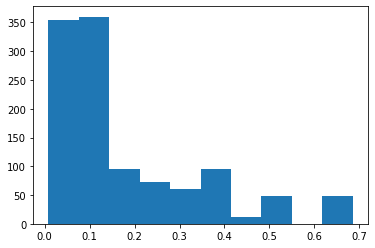

In [32]:
plt.hist(DF['cropland_share'])

In [24]:
DF.to_csv(cwd[:-4]+'/Data/data_farmclass_state.csv', index=False)